In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [11]:
df = pd.read_csv("arson.txt", delimiter="^")

In [12]:
df

,STATE,FDID,INC_DATE,INC_NO,EXP_NO,VERSION,CASE_STAT,AVAIL_MFI,MOT_FACTS1,MOT_FACTS2,...,INIT_OB5,INIT_OB6,INIT_OB7,INIT_OB8,LAB_USED1,LAB_USED2,LAB_USED3,LAB_USED4,LAB_USED5,LAB_USED6
0,AK,13000,4082014,0000439,0,5.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,AK,13000,6162014,0000775,0,5.0,2.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,AK,13000,8232014,0001218,0,5.0,2.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,AK,13000,8302014,0001262,0,5.0,2.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,AK,13000,9242014,0001385,0,5.0,3.0,2,UU,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39011,WY,37329,4292014,0000550,0,5.0,1.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
39012,WY,37329,9012014,0001325,0,5.0,2.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
39013,WY,37635,6142014,0142,0,5.0,NaN,1,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
39014,WY,37635,6152014,0148,0,5.0,NaN,1,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [8]:
months = df['INC_DATE']//1000000
months.tail()

39011    4
39012    9
39013    6
39014    6
39015    3
Name: INC_DATE, dtype: int64

In [14]:
month, incidents = np.unique(months, return_counts = True)

<BarContainer object of 12 artists>

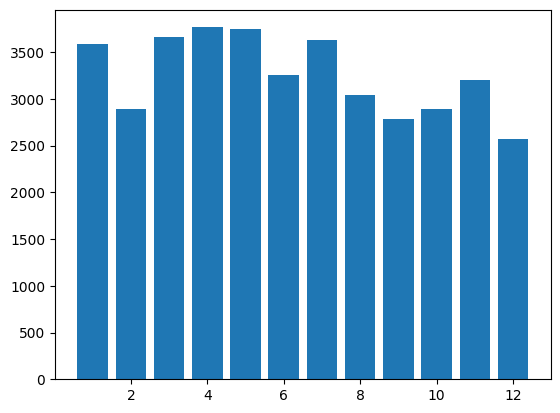

In [18]:
plt.bar(month, incidents)

In [37]:
s_incidents = df.STATE.value_counts(dropna=True)

<AxesSubplot: >

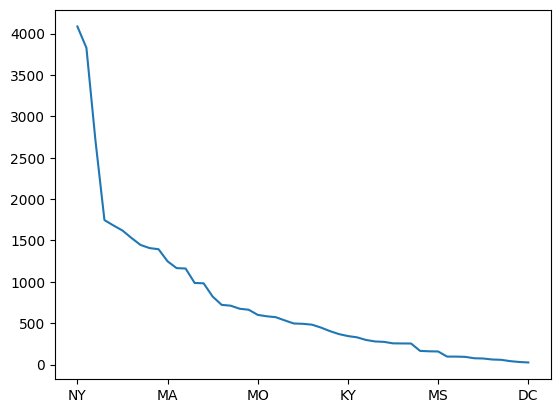

In [38]:
s_incidents.plot()

In [2]:
hazmat_df = pd.read_csv("hazmat.txt", delimiter="^")

In [3]:
hazmat_df

,INCIDENT_KEY,STATE,FDID,INC_DATE,INC_NO,EXP_NO,VERSION,REL_FROM,REL_STORY,POP_DENS,...,FACT_REL1,FACT_REL2,FACT_REL3,MIT_FACT1,MIT_FACT2,MIT_FACT3,EQ_INV_REL,HAZ_DISPO,HAZ_DEATH,HAZ_INJ
0,AK_11100_02072020_20473_0,AK,11100,2072020,20473,0,5.0,2.0,1.0,2.0,...,56,NaN,NaN,NaN,NaN,NaN,NNN,8.0,NaN,NaN
1,AK_11100_09282020_203531_0,AK,11100,9282020,203531,0,5.0,NaN,NaN,2.0,...,UU,NaN,NaN,NN,NaN,NaN,UUU,8.0,NaN,NaN
2,AK_13000_01142020_55_0,AK,13000,1142020,55,0,5.0,1.0,NaN,1.0,...,50,NaN,NaN,NaN,NaN,NaN,NaN,8.0,NaN,NaN
3,AK_23100_01022020_0000123_0,AK,23100,1022020,0000123,0,5.0,NaN,NaN,NaN,...,50,NaN,NaN,NaN,NaN,NaN,NaN,2.0,NaN,NaN
4,AK_23100_01032020_0000253_0,AK,23100,1032020,0000253,0,5.0,NaN,NaN,NaN,...,97,NaN,NaN,NaN,NaN,NaN,NaN,8.0,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12030,WY_39405_10212020_203532_0,WY,39405,10212020,203532,0,5.0,2.0,NaN,2.0,...,34,62.0,NaN,15,16.0,NaN,NaN,1.0,NaN,NaN
12031,WY_41403_03142020_102_0,WY,41403,3142020,102,0,5.0,2.0,NaN,3.0,...,33,78.0,NaN,31,NaN,NaN,229,1.0,NaN,NaN
12032,WY_43507_01242020_9_0,WY,43507,1242020,9,0,5.0,2.0,NaN,3.0,...,34,NaN,NaN,NN,NaN,NaN,NaN,2.0,NaN,NaN
12033,WY_43507_02262020_19_0,WY,43507,2262020,19,0,5.0,1.0,1.0,2.0,...,50,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN


In [6]:
state  = hazmat_df['STATE']
states = np.unique(state, return_counts = True)
states

(array(['AK', 'AL', 'AR', 'AZ', 'CA', 'CO', 'CT', 'DC', 'DE', 'FL', 'GA',
        'HI', 'IA', 'ID', 'IL', 'IN', 'KS', 'KY', 'LA', 'MA', 'MD', 'ME',
        'MI', 'MN', 'MO', 'MS', 'MT', 'NC', 'ND', 'NE', 'NH', 'NJ', 'NM',
        'NV', 'NY', 'OH', 'OK', 'OR', 'PA', 'RI', 'SC', 'SD', 'TN', 'TX',
        'UT', 'VA', 'VT', 'WA', 'WI', 'WV', 'WY'], dtype=object),
 array([ 144,   46,  128,  403,  781,  363,   71,  388,    3,  774,  238,
          60,   63,   18,  581,   98,   77,   30,  179,  644,  104,   53,
         127,   68,   32,   21,   20,  477,   19,   69,  163,   79,   42,
         245,  453,  292,   52,   88, 1915,   41,   72,    5,  104,  777,
         524,  573,   10,  294,  199,   10,   18]))

<AxesSubplot:>

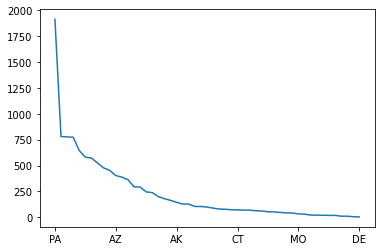

In [23]:
s_incidents = hazmat_df.STATE.value_counts(dropna=True)
s_incidents.plot()

In [26]:
months = hazmat_df['INC_DATE']//1000000
months.tail()

12030    10
12031     3
12032     1
12033     2
12034     7
Name: INC_DATE, dtype: int64

# loading civilian casuality data, firefighter casuality and basic module

In [2]:
civilian_casualities_df = pd.read_csv("civiliancasualty.txt", delimiter="^")

In [3]:
firefighter_casualities_df = pd.read_csv("ffcasualty.txt", delimiter="^")

In [11]:
basic_module_df = pd.read_csv("basicincident.txt", delimiter="^", dtype={"FDID":"string", "INC_NO":"string", "DEPT_STA":"string", "SHIFT": "string", "ALARMS": "string", "DISTRICT": "string"})

/var/folders/k_/_4lj__091bqb09hb5sr71tjm0000gn/T/ipykernel_2636/245177345.py:1: DtypeWarning: Columns (4,7,15,16,17,18,19,20,38,41) have mixed types. Specify dtype option on import or set low_memory=False.
  basic_module_df = pd.read_csv("basicincident.txt", delimiter="^", dtype={"FDID":"string"})


In [15]:
basic_module_df.iloc[:, 18]

0          11.0
1          45.0
2          86.0
3          86.0
4          12.0
           ... 
2181865      11
2181866      11
2181867      11
2181868       0
2181869      87
Name: ACT_TAK1, Length: 2181870, dtype: object